In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import numpy as np
import bidi.algorithm
import arabic_reshaper
import adhtools.utils

In [7]:
fpath = '/media/sf_VBox_Shared/Arabic/Analyses/Fiqh_final2/topicmodeling/fiqh-light10-20/'

In [8]:
df_topics = pd.read_csv(os.path.join(fpath, 'fiqh_light10_topics_20_labeled.csv'), sep=';', index_col=0).fillna('')

In [ ]:
df_topics['label'] = df_topics[['topic_level1', 'topic_level2']].apply(lambda r: ' - '.join([s for s in r if s!='']), axis=1)
df_topics

In [21]:
document_topics = pd.read_csv(os.path.join(fpath, 'document_topics_20.csv'), index_col=0).sort_index()
#df_topics = pd.read_csv(os.path.join(fpath, 'fiqh_roots_topics_20.csv'), index_col=0)
metadata = pd.read_csv(os.path.join(fpath, '../../metadata-chapters.csv'), index_col=0)

In [22]:
topic_names = df_topics['label']

In [23]:
def split_fname(fname):
    splitted = fname.split('-')
    bookname = splitted[0]
    if len(splitted)>1:
        chapter = int(splitted[-1].split('.')[0])
    else:
        chapter = 0
    return (bookname, chapter)

In [25]:
metadata['filename'] = metadata.filename.astype(str)

In [26]:
metadata_newind = metadata
metadata_newind.index = pd.MultiIndex.from_tuples(metadata.filename.map(split_fname))

In [27]:
ind = metadata_newind.index
book_names = sorted(ind.levels[0])

In [29]:
largest_topics = pd.DataFrame(document_topics.idxmax(axis=1))#, index=metadata_newind.index)
largest_topics.index = metadata_newind.index

largest_topics = pd.concat((largest_topics,  metadata_newind['ChapterLength'], metadata_newind['Number_of_tokens']), axis=1)

#largest_topics.index = new_ind
largest_topics = largest_topics.reset_index()
largest_topics.columns = ['book', 'chapter', 'topic', 'length', 'total_length']

In [30]:
book_dict = {b: i for i,b in enumerate(book_names)}

In [31]:
metadata_newind['topic'] = largest_topics.set_index(['book', 'chapter'])['topic']
metadata_newind['topic_name'] = [topic_names[int(topic)] for topic in metadata_newind['topic']]
metadata_newind['topic_level1'] = [df_topics.topic_level1[int(topic)] for topic in metadata_newind['topic']]
metadata_newind['topic_level2'] = [df_topics.topic_level2[int(topic)] for topic in metadata_newind['topic']]

In [33]:
metadata_newind.to_csv(os.path.join(fpath, 'chapters_metadata_topics.csv'))

In [34]:
largest_topics['x1'] = largest_topics.groupby('book')['length'].transform(pd.Series.cumsum)
largest_topics['x0'] = largest_topics['x1'] - largest_topics['length']

In [35]:
largest_topics['total_length'] = largest_topics.groupby('book')['x1'].transform(lambda l: [l.max()]*len(l))

In [36]:
largest_topics['perc0'] = largest_topics['x0'] / largest_topics['total_length']
largest_topics['perc1'] = largest_topics['x1'] / largest_topics['total_length']

In [37]:
largest_topics['label'] = [topic_names[int(t)] for t in largest_topics['topic']]

In [39]:
largest_topics.to_csv(os.path.join(fpath, 'largest_topics_20.csv'), index=False)

create color palette based on the two levels

In [40]:
nested_topics = dict(df_topics.groupby('topic_level1').agg(set)['topic_level2'])

In [41]:
level1_counts = {k: len(nested_topics[k]) for k in nested_topics}

In [42]:
# Count the number of distincts topics per highest level
level1_counts

{'legal reasoning': 1,
 'personal law': 2,
 'private law': 3,
 'procedural law': 1,
 'public law': 2,
 'ritual law': 5,
 'transmitted opinion': 4}

## Plot the topics

Each topic label gets a color assigned. Here we show the color per topic, in the table with the most important words per topic. The topics are sorted on label.

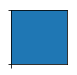

legal reasoning


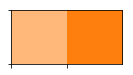

personal law - inheritance
personal law - marriage


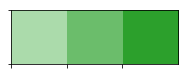

private law - contracts: estates
private law - contracts: sales
private law - slaves


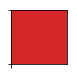

procedural law - litigation; proof


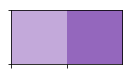

public law - homicide; punishments
public law - warfare


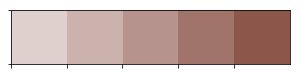

ritual law - aims-giving
ritual law - fasting; expiation
ritual law - pilgrimage and fasting
ritual law - prayer
ritual law - purity


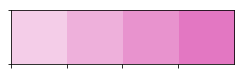

transmitted opinion - Mālikī authorities
transmitted opinion - general
transmitted opinion - prophetic hadith and early legal authorities
transmitted opinion - Ḥanafī authorities


In [78]:
color_dict = {}
start_colors = sns.color_palette(n_colors=len(level1_counts))
for i, topic_lev1 in enumerate(nested_topics):
    if topic_lev1 != 'noise':
        c = start_colors[i] #tuple((np.random.random() for _ in range(3)))
        level2_counts = level1_counts[topic_lev1]
        cmap_sub = sns.light_palette(c, level2_counts+1)[1:]
        sns.palplot(cmap_sub)
        plt.show()
        for j, topic_lev2 in enumerate(sorted(nested_topics[topic_lev1])):
            label = topic_lev1
            if topic_lev2 != '':
                label+= ' - ' + topic_lev2
            color_dict[label] = cmap_sub[j]
            print(label)
            

In [44]:
#color_list = sns.color_palette(n_colors=len(topic_names))
# color_list = sns.color_palette("muted", n_colors=10) + sns.color_palette("dark", n_colors=10)
# color_dict = {label: color_list[i] for i,label in enumerate(topic_names)}
color_dict['noise'] = 'grey'

In [45]:
import matplotlib.colors

def style_row(row):
    topic_id = int(row.name)
    topic_name = row.label
    color = matplotlib.colors.to_hex(color_dict[topic_name])
    attr = 'background-color: {}'.format(color)
    return [attr for v in  row]
df_topics.sort_values(['topic_level1', 'topic_level2']).style.apply(style_row, axis=1)

,0,1,2,3,4,5,6,7,8,9,topic_level1,topic_level2,label
topic,,,,,,,,,,,,,
11,شيخ,بخلاف,كلام,ول,ظاهر,شرح,فل,اذ,اول,ذكر,legal reasoning,,legal reasoning
12,ذكر,مذهب,احدهم,ول,وجه,شافع,ابو,فصل,مسال,ثان,legal reasoning,,legal reasoning
14,ام,صحيح,ول,ثان,اصل,اجماع,مطلق,عدم,اول,خلاف,legal reasoning,,legal reasoning
17,موص,ورث,ثلاث,نصف,عشر,ام,مال,اب,وص,ثلث,personal law,inheritance,personal law - inheritance
6,عد,فل,مهر,ام,حد,اذ,نكاح,ول,طلاق,زوج,personal law,marriage,personal law - marriage
15,دار,اخذ,ملك,عمل,فل,اذ,اجر,ول,ارض,مال,private law,contracts: estates,private law - contracts: estates
4,خيار,هذ,ول,بااع,اذ,قبض,عقد,ثمن,مشتر,بيع,private law,contracts: sales,private law - contracts: sales
19,مول,مكاتب,قيم,ملك,حر,ام,ول,مال,ولد,عتق,private law,slaves,private law - slaves
8,هذ,حق,حد,يد,اذ,مدع,قاض,اقرار,ول,شهاد,procedural law,litigation; proof,procedural law - litigation; proof


In [46]:
def plot_bar_per_book(largest_topics, xmin_col, xmax_col, book_names, topic_names, legend=True):
    book_dict = {b: i for i,b in enumerate(book_names)}

    plt.figure(figsize=(25, np.floor(len(book_names)*0.5)))
    ax = plt.gca()
    for topic_name in sorted(topic_names):
        largest_topics_sub = largest_topics[largest_topics['label']==topic_name]
        #color = color_list[topic] 
        color = color_dict[topic_name]

        y = [book_dict[s] for s in largest_topics_sub['book']]
        #x = largest_topics_sub['chapter']
        xmin = largest_topics_sub[xmin_col]
        xmax = largest_topics_sub[xmax_col]
        if topic_name != 'noise':
            ax.hlines(y, xmin, xmax, #marker='s', edgecolors=None, 
                      colors=np.array((color,)), lw=10,
                       label=bidi.algorithm.get_display(arabic_reshaper.reshape(topic_name)))
    ax.set_yticks(np.arange(len(book_dict)))
    ax.set_yticklabels(book_names)
    ax.set_xlim(0, largest_topics[xmax_col].max())
    ax.set_ylim(-0.5, len(book_names))
    if legend:
        plt.legend(fontsize='large')
    ax.invert_yaxis()
    #ax.set_facecolor('black')
    plt.show()

We plot the topics per book, based on the absolute length (in number of tokens) of the chapters in the book.

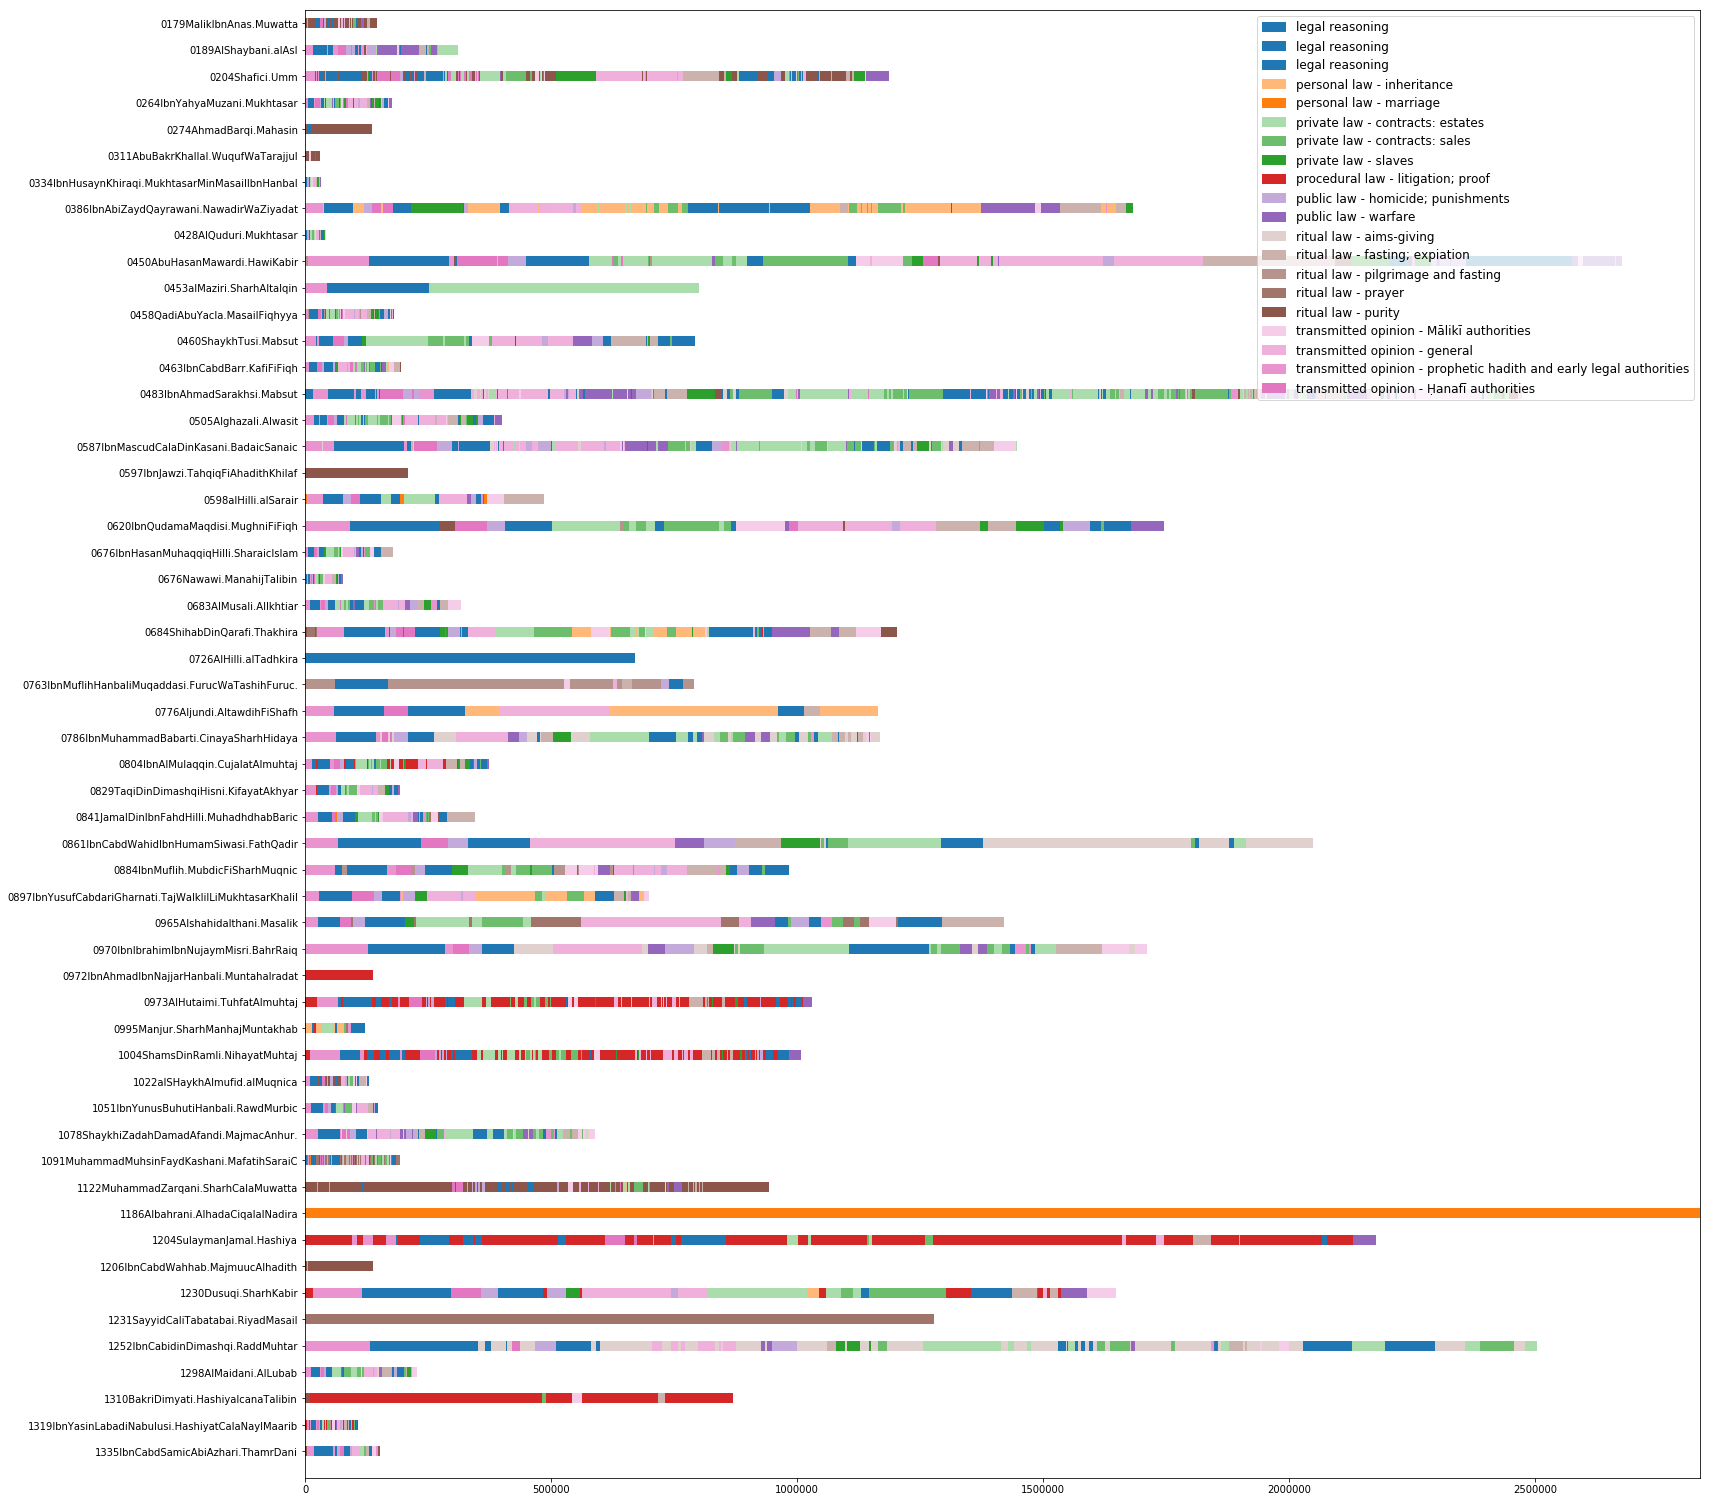

In [47]:
plot_bar_per_book(largest_topics, 'x0', 'x1', book_names, topic_names, legend=True)

Here we look at the distribution of topics per book, shown as percentages of the complete book.

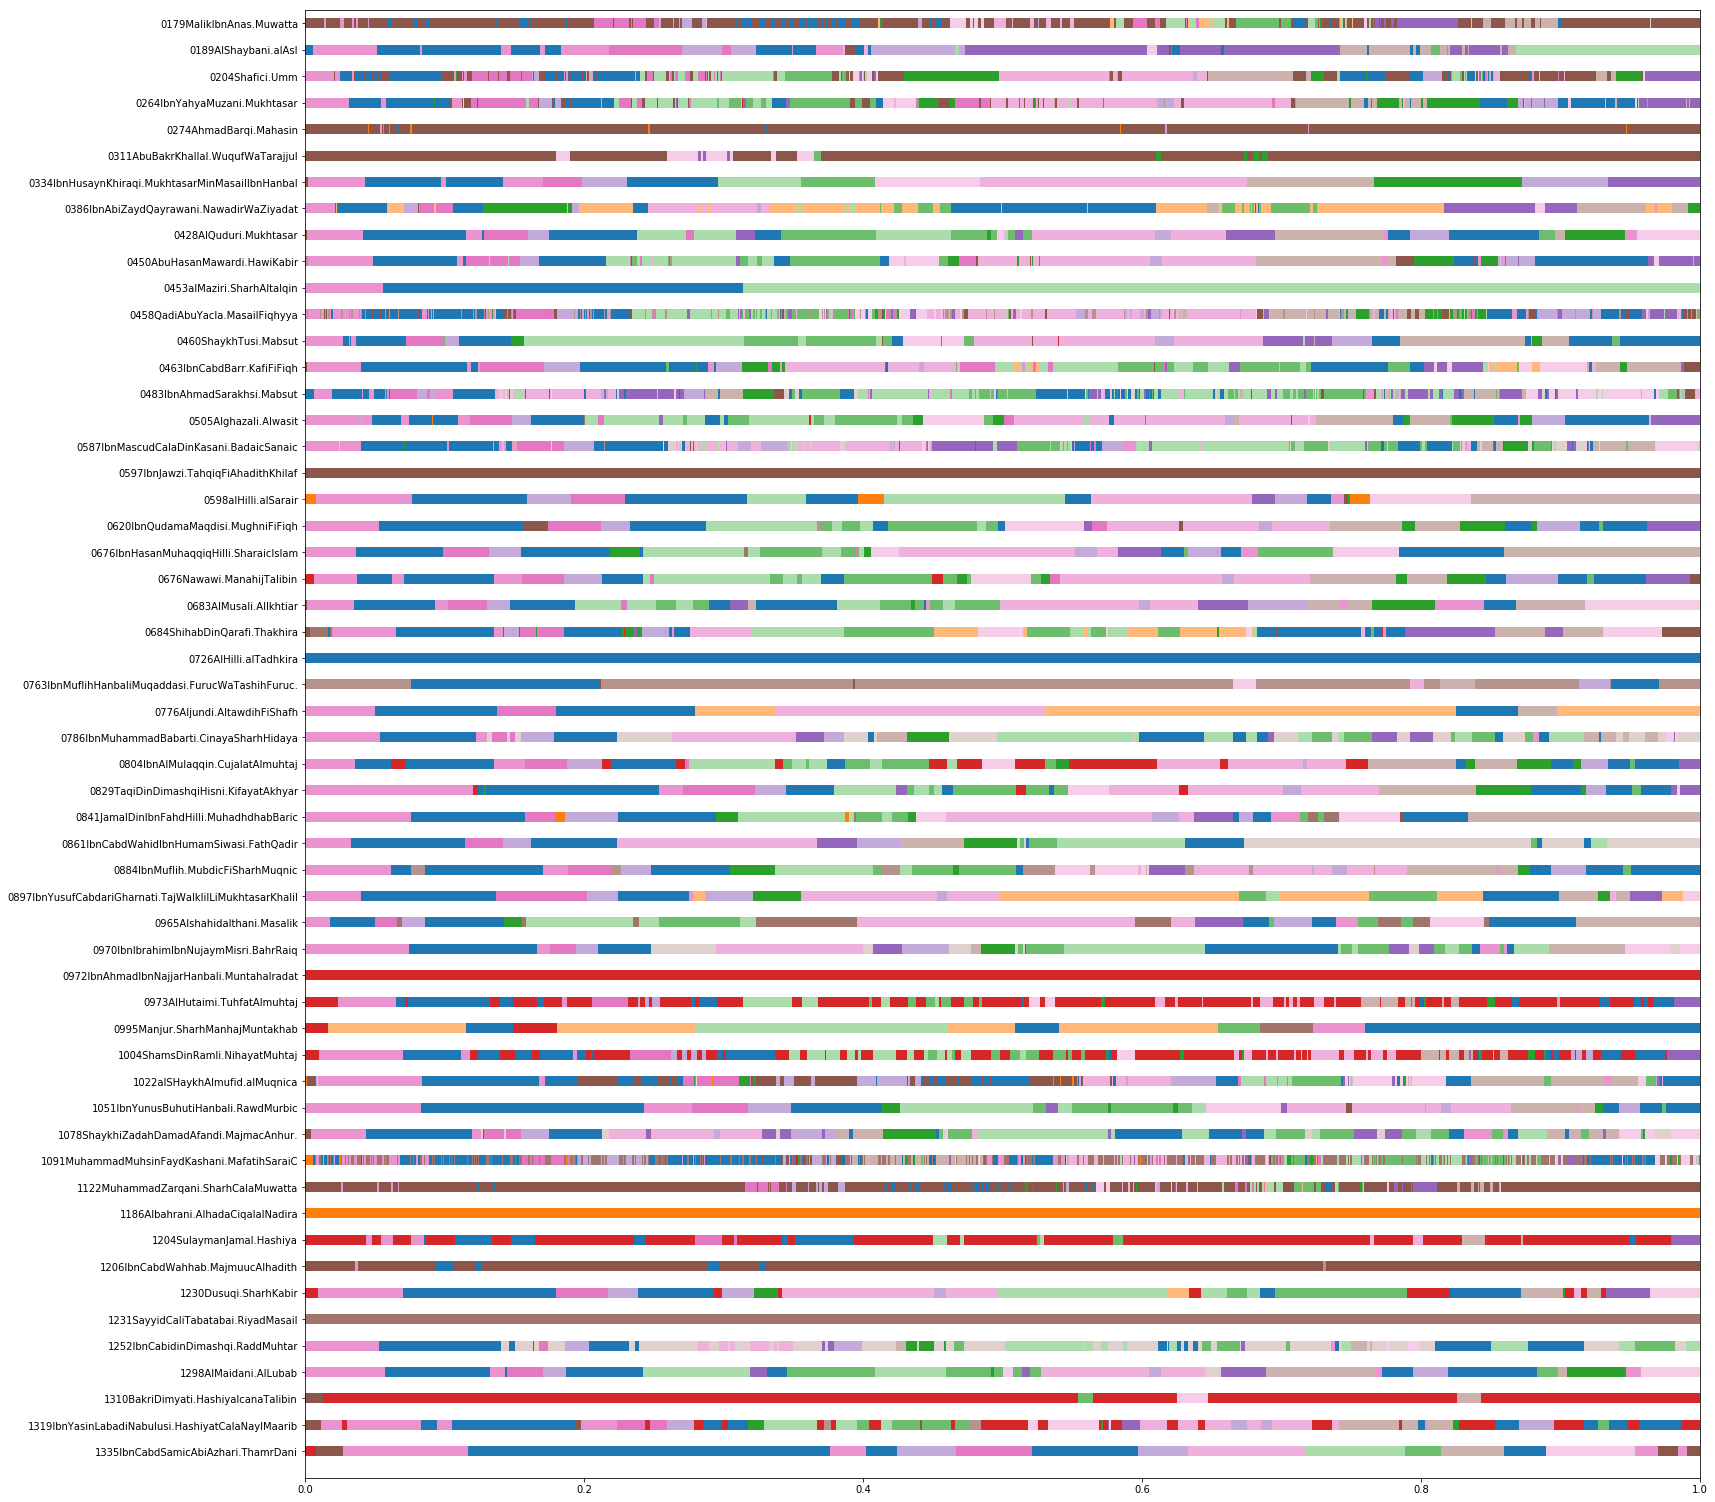

In [48]:
plot_bar_per_book(largest_topics, 'perc0', 'perc1', book_names, topic_names, legend=False)

Here is the same plot, but grouped per school.

مالكي


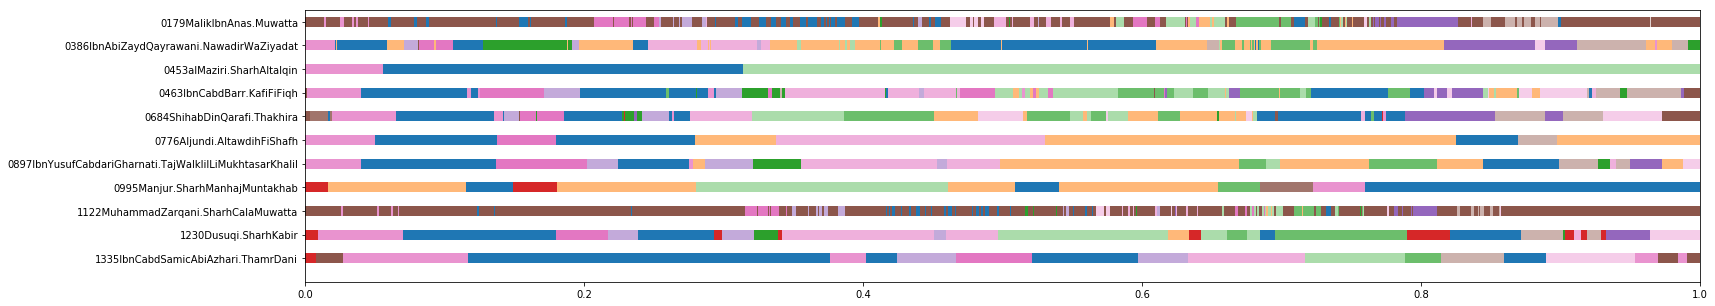

حنفي


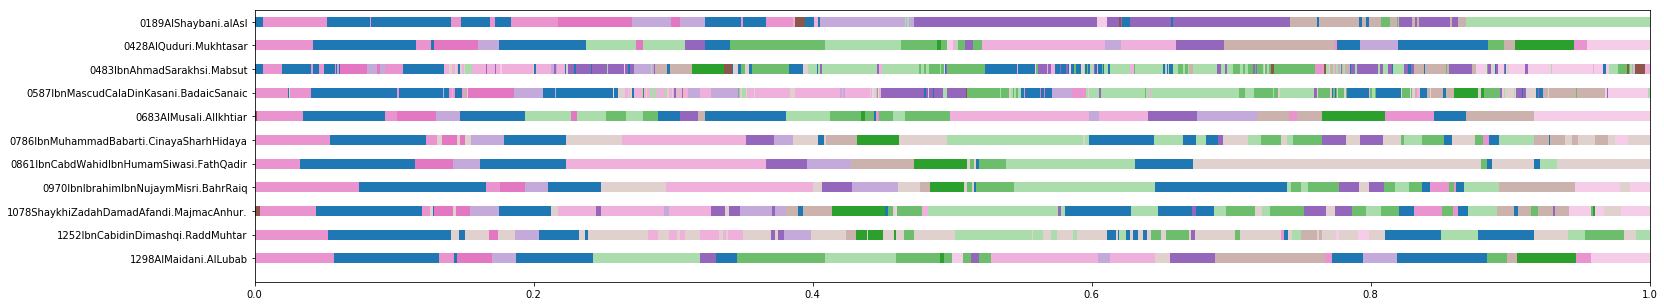

شافعي


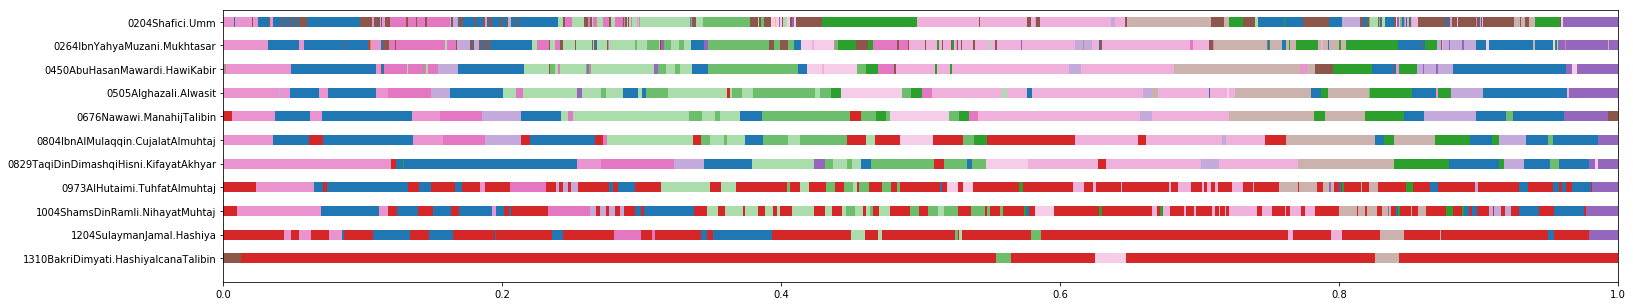

شيعي


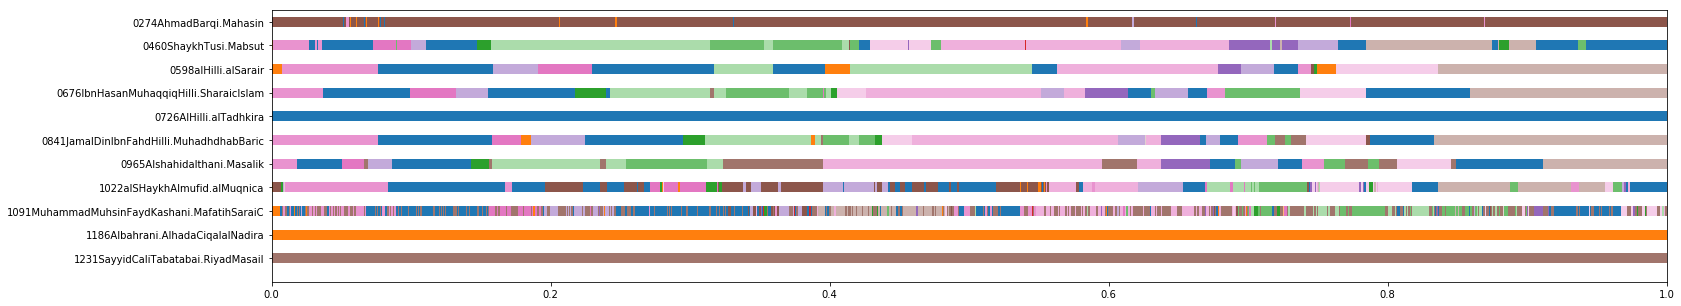

حنبلي


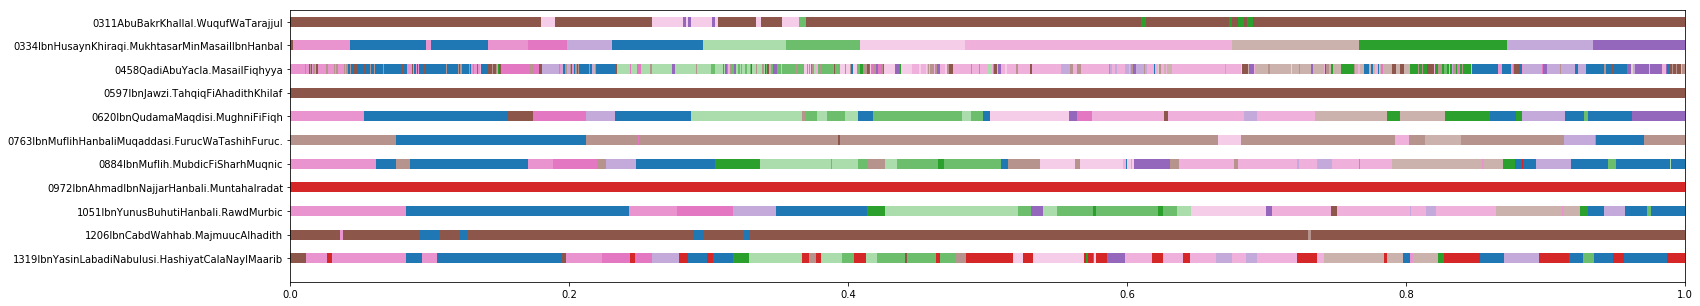

In [49]:
for subj in metadata.BookSUBJ.unique():
    if type(subj)==str:
        print(subj)
        ind_sub = metadata_newind[metadata_newind.BookSUBJ==subj].index.to_frame()
        ind_sub.columns = ['book', 'chapter']
        largest_topics_sub = largest_topics.merge(ind_sub, how='inner')
        plot_bar_per_book(largest_topics_sub, 'perc0', 'perc1', largest_topics_sub.book.unique(), topic_names, legend=False)

In [76]:
largest_topics['perc'] = largest_topics.perc1 - largest_topics.perc0

For each topic, what are the books that spent most time on that topic? (as percentage of the complete book). We also show the number of chapters with this topic in this book, because if the book consist of only 1 chapter, the book will have 100% one topic.

In [75]:
from IPython.display import display
for label in topic_names:
    print(label)
    grouped = largest_topics[largest_topics.label==label].groupby('book')
    #print(grouped['length'].aggregate((sum, len)).sort_values('sum', ascending=False)[:10])
    books_per_topic = grouped['perc'].aggregate((sum,len)).sort_values('sum', ascending=False)
    books_per_topic.columns = ['perc', 'nr_chapters']
    books_per_topic['perc'] = books_per_topic.perc.map(lambda x: '{:.1f}%'.format(x*100))
    books_per_topic['nr_chapters'] = books_per_topic.nr_chapters.map(int)
    display(books_per_topic[:10])
    print('\n')

public law - warfare


,perc,nr_chapters
book,,
0189AlShaybani.alAsl,29.1%,94
0483IbnAhmadSarakhsi.Mabsut,11.6%,115
0386IbnAbiZaydQayrawani.NawadirWaZiyadat,8.8%,8
0684ShihabDinQarafi.Thakhira,8.0%,9
0587IbnMascudCalaDinKasani.BadaicSanaic,7.0%,49
0334IbnHusaynKhiraqi.MukhtasarMinMasailIbnHanbal,6.6%,1
1078ShaykhiZadahDamadAfandi.MajmacAnhur.,5.9%,18
0786IbnMuhammadBabarti.CinayaSharhHidaya,5.8%,9
0428AlQuduri.Mukhtasar,5.5%,7




public law - homicide; punishments


,perc,nr_chapters
book,,
0189AlShaybani.alAsl,11.2%,24
0334IbnHusaynKhiraqi.MukhtasarMinMasailIbnHanbal,9.4%,3
1022alSHaykhAlmufid.alMuqnica,8.7%,26
1335IbnCabdSamicAbiAzhari.ThamrDani,7.8%,3
0458QadiAbuYacla.MasailFiqhyya,7.7%,62
0676Nawawi.ManahijTalibin,7.3%,5
0841JamalDinIbnFahdHilli.MuhadhdhabBaric,6.8%,6
0587IbnMascudCalaDinKasani.BadaicSanaic,6.8%,45
0683AlMusali.AlIkhtiar,6.7%,4




transmitted opinion - Mālikī authorities


,perc,nr_chapters
book,,
0483IbnAhmadSarakhsi.Mabsut,8.3%,65
0683AlMusali.AlIkhtiar,8.3%,2
0684ShihabDinQarafi.Thakhira,8.0%,35
0334IbnHusaynKhiraqi.MukhtasarMinMasailIbnHanbal,7.6%,7
0598alHilli.alSarair,7.3%,3
1022alSHaykhAlmufid.alMuqnica,6.8%,31
0676IbnHasanMuhaqqiqHilli.SharaicIslam,6.8%,2
0311AbuBakrKhallal.WuqufWaTarajjul,6.6%,11
0841JamalDinIbnFahdHilli.MuhadhdhabBaric,6.5%,2




ritual law - purity


,perc,nr_chapters
book,,
0597IbnJawzi.TahqiqFiAhadithKhilaf,100.0%,9
0274AhmadBarqi.Mahasin,98.5%,377
1206IbnCabdWahhab.MajmuucAlhadith,96.5%,98
0311AbuBakrKhallal.WuqufWaTarajjul,90.8%,66
1122MuhammadZarqani.SharhCalaMuwatta,81.7%,409
0179MalikIbnAnas.Muwatta,59.9%,431
0204Shafici.Umm,21.0%,247
1022alSHaykhAlmufid.alMuqnica,18.0%,80
0458QadiAbuYacla.MasailFiqhyya,5.9%,41




private law - contracts: sales


,perc,nr_chapters
book,,
0483IbnAhmadSarakhsi.Mabsut,13.8%,112
1298AlMaidani.AlLubab,13.0%,13
0684ShihabDinQarafi.Thakhira,12.4%,18
0428AlQuduri.Mukhtasar,12.1%,12
0676IbnHasanMuhaqqiqHilli.SharaicIslam,11.5%,14
0463IbnCabdBarr.KafiFiFiqh,11.4%,39
0460ShaykhTusi.Mabsut,10.9%,16
1230Dusuqi.SharhKabir,10.9%,10
1078ShaykhiZadahDamadAfandi.MajmacAnhur.,10.4%,18




ritual law - prayer


,perc,nr_chapters
book,,
1231SayyidCaliTabatabai.RiyadMasail,100.0%,23
1091MuhammadMuhsinFaydKashani.MafatihSaraiC,32.0%,408
0965Alshahidalthani.Masalik,14.0%,13
0995Manjur.SharhManhajMuntakhab,3.8%,1
0841JamalDinIbnFahdHilli.MuhadhdhabBaric,2.0%,3
0684ShihabDinQarafi.Thakhira,1.4%,18
0676IbnHasanMuhaqqiqHilli.SharaicIslam,0.3%,1
0897IbnYusufCabdariGharnati.TajWaIklilLiMukhtasarKhalil,0.0%,1
0505Alghazali.Alwasit,0.0%,2




personal law - marriage


,perc,nr_chapters
book,,
1186Albahrani.AlhadaCiqalalNadira,100.0%,1
0598alHilli.alSarair,4.0%,4
1091MuhammadMuhsinFaydKashani.MafatihSaraiC,1.2%,13
0841JamalDinIbnFahdHilli.MuhadhdhabBaric,1.0%,2
1022alSHaykhAlmufid.alMuqnica,0.7%,8
0274AhmadBarqi.Mahasin,0.6%,12
0460ShaykhTusi.Mabsut,0.1%,1
0505Alghazali.Alwasit,0.0%,3
1231SayyidCaliTabatabai.RiyadMasail,0.0%,1




ritual law - pilgrimage and fasting


,perc,nr_chapters
book,,
0763IbnMuflihHanbaliMuqaddasi.FurucWaTashihFuruc.,75.2%,23
0458QadiAbuYacla.MasailFiqhyya,8.2%,111
0884IbnMuflih.MubdicFiSharhMuqnic,6.6%,12
1319IbnYasinLabadiNabulusi.HashiyatCalaNaylMaarib,1.3%,2
0450AbuHasanMawardi.HawiKabir,0.4%,5
0620IbnQudamaMaqdisi.MughniFiFiqh,0.3%,1
1206IbnCabdWahhab.MajmuucAlhadith,0.2%,1
0264IbnYahyaMuzani.Mukhtasar,0.1%,1
0684ShihabDinQarafi.Thakhira,0.0%,1




procedural law - litigation; proof


,perc,nr_chapters
book,,
0972IbnAhmadIbnNajjarHanbali.MuntahaIradat,100.0%,1
1310BakriDimyati.HashiyaIcanaTalibin,93.8%,18
1204SulaymanJamal.Hashiya,77.6%,74
0973AlHutaimi.TuhfatAlmuhtaj,58.0%,158
1004ShamsDinRamli.NihayatMuhtaj,40.9%,127
1319IbnYasinLabadiNabulusi.HashiyatCalaNaylMaarib,19.0%,27
0804IbnAlMulaqqin.CujalatAlmuhtaj,16.5%,13
1230Dusuqi.SharhKabir,7.0%,13
0995Manjur.SharhManhajMuntakhab,4.8%,2




transmitted opinion - Ḥanafī authorities


,perc,nr_chapters
book,,
0264IbnYahyaMuzani.Mukhtasar,8.7%,39
0463IbnCabdBarr.KafiFiFiqh,8.1%,25
0897IbnYusufCabdariGharnati.TajWaIklilLiMukhtasarKhalil,6.5%,1
0204Shafici.Umm,6.1%,115
0189AlShaybani.alAsl,5.9%,8
1335IbnCabdSamicAbiAzhari.ThamrDani,5.4%,3
0179MalikIbnAnas.Muwatta,5.3%,25
0829TaqiDinDimashqiHisni.KifayatAkhyar,5.2%,5
0450AbuHasanMawardi.HawiKabir,5.0%,28




ritual law - aims-giving


,perc,nr_chapters
book,,
1252IbnCabidinDimashqi.RaddMuhtar,38.0%,90
0861IbnCabdWahidIbnHumamSiwasi.FathQadir,30.6%,27
0786IbnMuhammadBabarti.CinayaSharhHidaya,20.3%,28
0970IbnIbrahimIbnNujaymMisri.BahrRaiq,8.7%,8
0587IbnMascudCalaDinKasani.BadaicSanaic,5.0%,66
1078ShaykhiZadahDamadAfandi.MajmacAnhur.,3.6%,8
0483IbnAhmadSarakhsi.Mabsut,2.7%,22
1298AlMaidani.AlLubab,1.1%,1
0458QadiAbuYacla.MasailFiqhyya,0.2%,2




legal reasoning


,perc,nr_chapters
book,,
0726AlHilli.alTadhkira,100.0%,1
1335IbnCabdSamicAbiAzhari.ThamrDani,38.9%,9
0995Manjur.SharhManhajMuntakhab,30.5%,5
1051IbnYunusBuhutiHanbali.RawdMurbic,27.7%,35
0453alMaziri.SharhAltalqin,25.8%,9
1022alSHaykhAlmufid.alMuqnica,25.6%,69
0884IbnMuflih.MubdicFiSharhMuqnic,25.2%,74
0829TaqiDinDimashqiHisni.KifayatAkhyar,25.1%,39
0598alHilli.alSarair,24.3%,8




legal reasoning


,perc,nr_chapters
book,,
0726AlHilli.alTadhkira,100.0%,1
1335IbnCabdSamicAbiAzhari.ThamrDani,38.9%,9
0995Manjur.SharhManhajMuntakhab,30.5%,5
1051IbnYunusBuhutiHanbali.RawdMurbic,27.7%,35
0453alMaziri.SharhAltalqin,25.8%,9
1022alSHaykhAlmufid.alMuqnica,25.6%,69
0884IbnMuflih.MubdicFiSharhMuqnic,25.2%,74
0829TaqiDinDimashqiHisni.KifayatAkhyar,25.1%,39
0598alHilli.alSarair,24.3%,8




transmitted opinion - general


,perc,nr_chapters
book,,
0965Alshahidalthani.Masalik,21.7%,6
0505Alghazali.Alwasit,19.9%,43
0776Aljundi.AltawdihFiShafh,19.3%,2
0460ShaykhTusi.Mabsut,19.3%,37
0334IbnHusaynKhiraqi.MukhtasarMinMasailIbnHanbal,19.1%,9
0450AbuHasanMawardi.HawiKabir,19.0%,43
0264IbnYahyaMuzani.Mukhtasar,18.8%,86
0458QadiAbuYacla.MasailFiqhyya,18.3%,132
0829TaqiDinDimashqiHisni.KifayatAkhyar,17.4%,20




legal reasoning


,perc,nr_chapters
book,,
0726AlHilli.alTadhkira,100.0%,1
1335IbnCabdSamicAbiAzhari.ThamrDani,38.9%,9
0995Manjur.SharhManhajMuntakhab,30.5%,5
1051IbnYunusBuhutiHanbali.RawdMurbic,27.7%,35
0453alMaziri.SharhAltalqin,25.8%,9
1022alSHaykhAlmufid.alMuqnica,25.6%,69
0884IbnMuflih.MubdicFiSharhMuqnic,25.2%,74
0829TaqiDinDimashqiHisni.KifayatAkhyar,25.1%,39
0598alHilli.alSarair,24.3%,8




private law - contracts: estates


,perc,nr_chapters
book,,
0453alMaziri.SharhAltalqin,68.6%,1
0483IbnAhmadSarakhsi.Mabsut,19.4%,149
0786IbnMuhammadBabarti.CinayaSharhHidaya,18.1%,27
0995Manjur.SharhManhajMuntakhab,18.0%,2
0598alHilli.alSarair,17.2%,2
0460ShaykhTusi.Mabsut,17.0%,5
1078ShaykhiZadahDamadAfandi.MajmacAnhur.,16.1%,24
0587IbnMascudCalaDinKasani.BadaicSanaic,16.1%,89
1230Dusuqi.SharhKabir,15.1%,7




transmitted opinion - prophetic hadith and early legal authorities


,perc,nr_chapters
book,,
1335IbnCabdSamicAbiAzhari.ThamrDani,13.8%,11
0829TaqiDinDimashqiHisni.KifayatAkhyar,13.7%,13
1051IbnYunusBuhutiHanbali.RawdMurbic,11.9%,13
0189AlShaybani.alAsl,11.2%,24
1319IbnYasinLabadiNabulusi.HashiyatCalaNaylMaarib,10.6%,13
0970IbnIbrahimIbnNujaymMisri.BahrRaiq,10.0%,4
0841JamalDinIbnFahdHilli.MuhadhdhabBaric,9.7%,2
1022alSHaykhAlmufid.alMuqnica,8.7%,17
0683AlMusali.AlIkhtiar,8.6%,11




personal law - inheritance


,perc,nr_chapters
book,,
0776Aljundi.AltawdihFiShafh,45.5%,4
0995Manjur.SharhManhajMuntakhab,36.1%,7
0386IbnAbiZaydQayrawani.NawadirWaZiyadat,32.4%,91
0897IbnYusufCabdariGharnati.TajWaIklilLiMukhtasarKhalil,29.1%,19
0684ShihabDinQarafi.Thakhira,10.5%,11
0463IbnCabdBarr.KafiFiFiqh,3.3%,10
0179MalikIbnAnas.Muwatta,1.9%,12
1230Dusuqi.SharhKabir,1.5%,1
1122MuhammadZarqani.SharhCalaMuwatta,0.3%,5




ritual law - fasting; expiation


,perc,nr_chapters
book,,
0841JamalDinIbnFahdHilli.MuhadhdhabBaric,16.7%,3
0598alHilli.alSarair,16.4%,2
0676IbnHasanMuhaqqiqHilli.SharaicIslam,14.1%,3
0460ShaykhTusi.Mabsut,11.1%,17
1022alSHaykhAlmufid.alMuqnica,11.0%,25
0683AlMusali.AlIkhtiar,9.6%,8
0450AbuHasanMawardi.HawiKabir,9.6%,10
0804IbnAlMulaqqin.CujalatAlmuhtaj,9.3%,10
0334IbnHusaynKhiraqi.MukhtasarMinMasailIbnHanbal,9.1%,5




private law - slaves


,perc,nr_chapters
book,,
0334IbnHusaynKhiraqi.MukhtasarMinMasailIbnHanbal,10.6%,1
0204Shafici.Umm,9.8%,19
0264IbnYahyaMuzani.Mukhtasar,8.5%,36
0386IbnAbiZaydQayrawani.NawadirWaZiyadat,7.2%,10
0505Alghazali.Alwasit,5.8%,13
0450AbuHasanMawardi.HawiKabir,5.2%,10
0676Nawawi.ManahijTalibin,5.0%,7
0683AlMusali.AlIkhtiar,4.8%,2
0804IbnAlMulaqqin.CujalatAlmuhtaj,4.7%,7


## Barplots

In [50]:
def plot_bars_per_topic(df, topic_names, col1, col2='ChapterLength', aggfunc=sum, reshape_col1=False):
    plt.figure(figsize=(15,10))
    ax = plt.gca()
    values = df.groupby([col1, 'topic_name'])[col2].apply(aggfunc).sort_values()
    values = values.unstack().fillna(0)
    values = values.reindex(sorted(values.index), axis=0)
    #sorted_index = values.sum(axis=1).sort_values(ascending=False).index
    #values = values.loc[sorted_index,:]
    ind0 = values.index
    ind1 = values.columns
    x = np.arange(len(ind0))
    last_y = np.repeat(0, len(ind0))
    for t, topic_name in enumerate(ind1):
        y = values[topic_name]
        if topic_name != 'noise':
            ax.bar(x, y, bottom=last_y, color=color_dict[topic_name],
                    label=bidi.algorithm.get_display(arabic_reshaper.reshape(topic_name)))
            last_y = last_y+y
    if reshape_col1:
        xlabels = [bidi.algorithm.get_display(arabic_reshaper.reshape(l)) for l in ind0]
    else:
        xlabels = ind0
    ax.set_xticks(x)
    ax.set_xticklabels(xlabels, rotation=90)
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2)
    plt.show()

Here we see the total number of tokens in the corpus per topic, grouped by school.

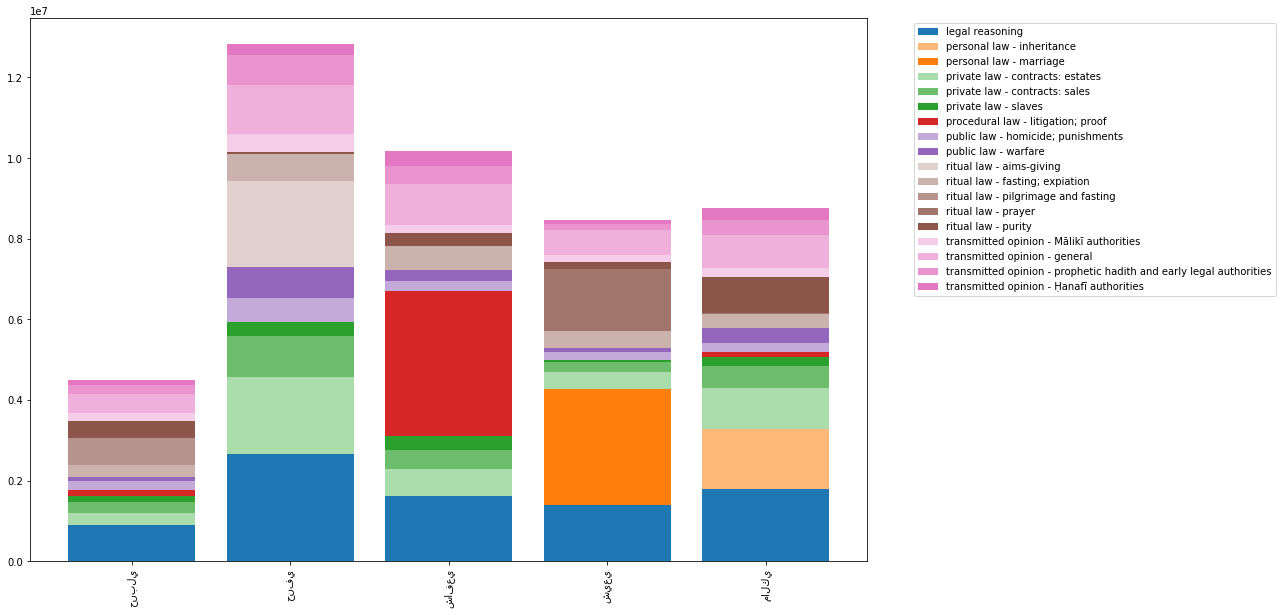

In [51]:
plot_bars_per_topic(metadata_newind, topic_names, 'BookSUBJ')

This is only the number the chapters (so not normalized by chapter length).

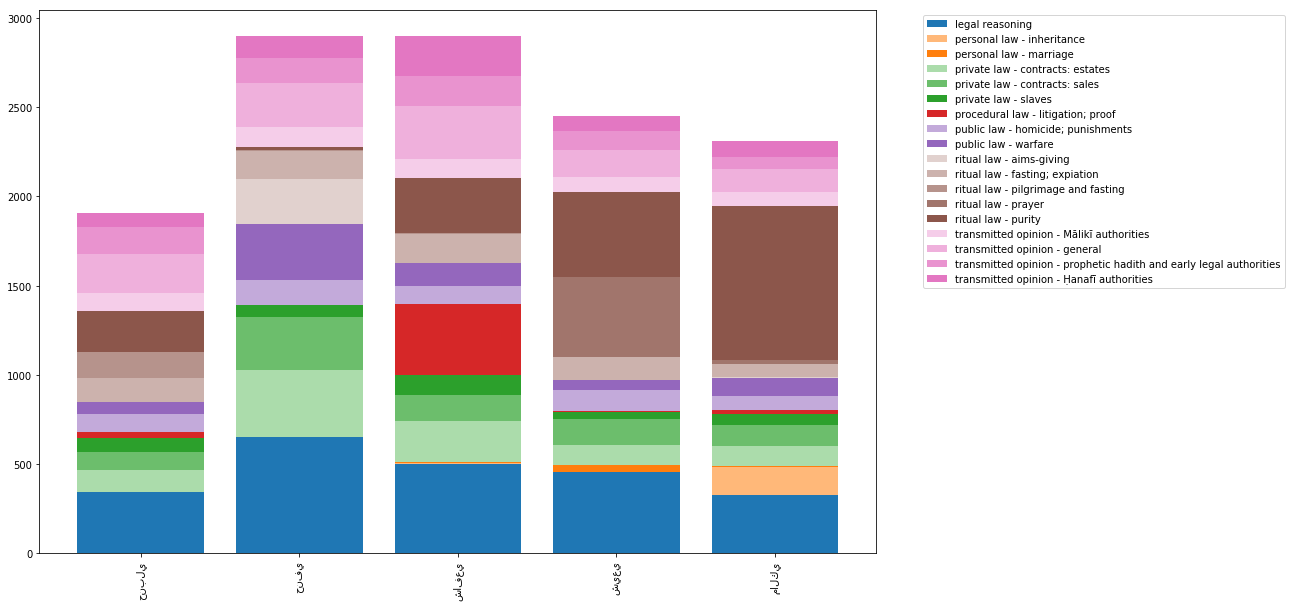

In [52]:
# Here we see only the number of chapters
plot_bars_per_topic(metadata_newind, topic_names, 'BookSUBJ', aggfunc=len)

This is the number of tokens per topic, per geographica area

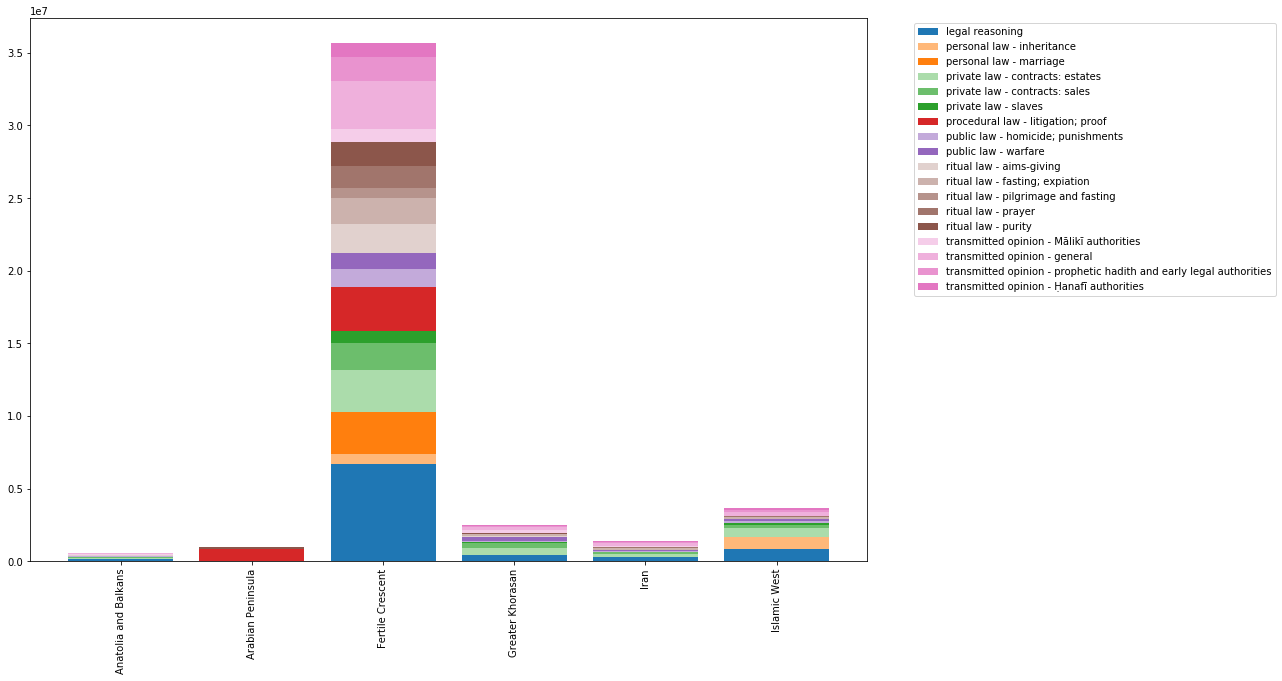

In [53]:
plot_bars_per_topic(metadata_newind, topic_names, 'Author_Geographical_Area')

In [54]:
import re
metadata_newind['Century_num'] = metadata_newind.Century.apply(lambda s: int(re.match('^[0-9]*', s).group(0)))

And the number of tokens per topic, per century

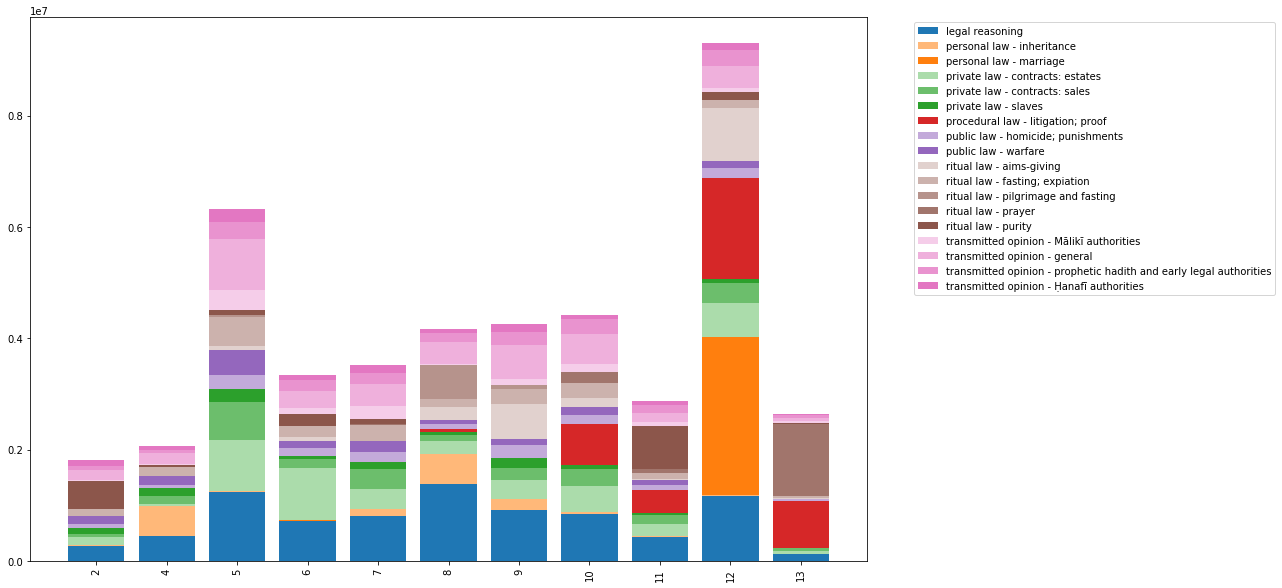

In [55]:
plot_bars_per_topic(metadata_newind, topic_names, 'Century_num')

## Volume and chapter titles

In [56]:
def style_color(df, color):
    st = 'background-color: {}'.format(color)
    return df.style.apply(lambda r: [st]*len(r))

# Print the most common titles per topic
for t, topic_name in enumerate(topic_names):
    #if topic_name != 'noise':
    meta_sub = metadata_newind[metadata_newind['topic_name']==topic_name]
    color = matplotlib.colors.to_hex(color_dict[topic_name])
    #print(t, topic_name)
    display(style_color(pd.DataFrame([topic_name], index=[t], columns=['label']), color=color))
    print("Volumes:")
    for v in meta_sub.Level1Title.value_counts().head(10).index:
        print(v)
    print("\nChapters:")
    for c in meta_sub.Level2Title.value_counts().head(10).index:
        print(c)
    print('\n')

,label
0,public law - warfare


Volumes:
-
كتاب المكاتب
كتاب العتق
كتاب باب إغماض الميت
كتاب العتاق
كتاب المأذون الكبير
كتاب الولاء
كتاب الأقضية واليمين مع الشاهد وما دخل فيه من اختلاف الحديث وغير
كتاب العتق والمدبر والمكاتب وأم الولد
كتاب المأذون

Chapters:
-
باب الاستيلاد
باب التدبير
باب من يعتق على الرجل والمرأة إذا علما
باب
بابفيه ذكر شراء كسور السؤال وفى الزبل يجتمع فى أرض حبس هل يعمل به طوب من
مسألة
الباب الثامن والعشرون في الحلى
باب الولاء
باب جامع العتق واذا قال الرجل لعبده أنت حر او




,label
1,public law - homicide; punishments


Volumes:
-
كتاب الأيمان
كتاب الصيام
كتاب الصوم
كتاب مفاتيح الصلاة فلا نعيده في الصحيح هما واحد إذا قصرت أفطرت إذا أفطرت قصرت
كتاب الأيمان والنذور والكفارات
كتاب باب إغماض الميت
كتاب مفاتيح النذور العهود
كتاب النكاح وفيما يتعلق به من المهر والخلع والطلاق والرجعة والإيلاء والظهار والرضاع والعدة
كتاب الزكاة مسائل في حكم مانع الزكاة من امتنع عن إخراج الزكاة بخلا وقاتل عليها مسألة واختلفت

Chapters:
-
باب الاعتكاف
باب صوم التطوع
باب صدقة الفطر
باب
باب الظهار
مسألة
باب الاستيلاد
باب جامع الأيمان
باب من تلزمه الزكاة وما تجب فيه مراده بما تجب فيه شروطه وإلا فقد بين ما تجب فيه الزكاة فيما مضى شروط وجوب زكاة المال أي السالف ذكره وهو الحيوان والنبات وجوهر النقدين والتجارة والمعدن والركاز الإسلام أى فلا تجب على كافر أصلي بمعنى أنه لا يطالب بها في حال كفره ولا بعد إسلامه نعم يعاقب عليها في الأخرى والحرية أي فلا زكاة على قن لعدم ملكه وتلزم المرتد أي إذا مضي عليه حول في الردة بعد ملك النصاب إن أبقينا ملكه ومؤاخذة له بحكم الإسلام فإن قلنا أن ملكه زال فلا أو موقوف فموقوفة وهو الأصح أما إذا وجبت الزكاة 

,label
2,transmitted opinion - Mālikī authorities


Volumes:
كتاب الفرائض
كتاب الوصايا
-
كتاب الفرائض والمواريث
كتاب باب إغماض الميت
كتاب الفرائض والمواريث روي عن النبي صلى الله عليه وآله أنه قال
كتاب الوكالة
كتاب مفاتيح الفرائض المواريث
كتاب العتق
كتاب العين والدين

Chapters:
-
باب
باب ذوي الأرحام
باب ميراث
باب جامع الوصايا ينبغي للمسلم ان لا
باب ميراث الجد
باب البغاة
باب الأوصياء
باب ميراث الحمل
باب العصبات




,label
3,ritual law - purity


Volumes:
-
كتاب
كتاب العتق
كتاب الحج باب
كتاب الحج باب الغسل للإهلال
كتاب باب إغماض الميت
كتاب الحج باب فرض الحج على من وجب عليه الحج
كتاب وقوت الصلاة
كتاب الزكاة
كتاب القاضي إلى القاضي

Chapters:
باب
-
باب ما جاء في
باب ما
باب السبق باب السبق وللبخاري عن ابن عمر قال أجرى النبي صلى الله عليه وسلم
باب القرض باب القرض وعن عبد الله بن أبي ربيعة أن النبي صلى الله عليه وسلم
باب ما جاء
ثواب
باب مختصر زيارته
باب الحاق النسب باب إلحاق النسب عن عائشة رضي الله عنها أنها قالت إن رسول




,label
4,private law - contracts: sales


Volumes:
كتاب مفاتيح المطاعم المشارب أن للاصطياد في الشرع
كتاب المزارعة
كتاب المضاربة
كتاب الإجارة
كتاب الغصب
كتاب القسمة
كتاب العارية
كتاب الشركة
كتاب الإجارات
كتاب باب إغماض الميت

Chapters:
-
باب الرجوع عن الشهادة
باب السلم
باب الصرف
باب الضمان شرط الضامن الرشد
باب اللقطة
باب المضارب يضارب
مهمة فرع لو قال رجل غصبنا من فلان ألف درهم وكنا عشرة قال محمد بن الحسن لا يصدق ويلزمه الكل وقال زفر يقبل قوله مع يمينه قال في البيان
باب الإجارة
باب القسمة




,label
5,ritual law - prayer


Volumes:
كتاب مفاتيح المطاعم المشارب أن للاصطياد في الشرع
كتاب مفاتيح الصلاة
كتاب مفاتيح المناكح المواليد
كتاب مفاتيح الحسبة الحدود
كتاب مفاتيح الصلاة فلا نعيده في الصحيح هما واحد إذا قصرت أفطرت إذا أفطرت قصرت
كتاب مفاتيح الحج
كتاب مفاتيح العطايا المروات
-
كتاب مفاتيح الزكاة
كتاب مفاتيح القضاء الشهادات

Chapters:
-
مفتاح ما يشترط مراعاته في الجماعة
مفتاح حكم شهادة ولد الزنا
مفتاح لا يبنى بناء أعلى من الكعبة
مفتاح عدم جواز نكاح الكوافر للمسلم
مفتاح من يجب عليه الطواف
مفتاح ما لو اجتمع عيد جمعة
مفتاح طريق ثبوت الوصية بالمال
مفتاح حكم الشركة في الصيد
مفتاح من يكره معاملته




,label
6,personal law - marriage


Volumes:
-
كتاب مفاتيح الصلاة
كتاب مفاتيح الزكاة
كتاب مفاتيح المناكح المواليد
كتاب مفاتيح المطاعم المشارب
كتاب مفاتيح الحسبة الحدود
كتاب المكاسب
كتاب الإجارة
كتاب مفاتيح الصلاة فلا نعيده في الصحيح هما واحد إذا قصرت أفطرت إذا أفطرت قصرت
كتاب الجمعة

Chapters:
-
ثواب المصلى للفريضة عنه عن موسى بن القاسم عن علي بن جعفر عن أخيه موسى بن جعفر عن أبي
الباب الخامس في النزاع في الصداق
باب كذا في جميع ما عندي من نسخ المحاسن عنه عن صالح بن السندي عن
ثواب ذكر الله في الغافلين عنه عن النوفلي عن السكوني عن أبي عبد
الباب العشرون في جميع أدلة المجتهدين وتصرفات المكلفين
القسامة لما كان أمر القتيل في بعض الأحوال يئول
مفتاح صلاة جعفر الطيار
باب الشيعة عنه عن الحسن بن محبوب عن
مفتاح استحباب ثقب أذن المولود




,label
7,ritual law - pilgrimage and fasting


Volumes:
كتاب الطهارة مسائل في أحكام المياه الوضوء بالماء المتغير
كتاب النكاح وفيما يتعلق به من المهر والخلع والطلاق والرجعة والإيلاء والظهار والرضاع والعدة
كتاب الحج من أحرم بالحج عن غيره وهو لم يحج عن نفسه مسألة اختلف أصحابنا رحمة الله عليهم
كتاب السير
كتاب الزكاة مسائل في حكم مانع الزكاة من امتنع عن إخراج الزكاة بخلا وقاتل عليها مسألة واختلفت
كتاب الوديعة وقسم الفيء والغنيمة
كتاب البيوع وما يتعلق به من العقود بيع من غير رؤية المبيع ولا وصفه مسألة واختلفت الرواية عن
كتاب العتق والمدبر والمكاتب وأم الولد
كتاب
كتاب الجنائز مسائل في عيادة المريض عيادة أهل الذمة مسألة واختلفت هل يكره للمسلم عيادة اليهودي

Chapters:
-
مسألة
باب قتال أهل البغي
مسألة واختلفت في الحجر الكبير الذي له ثلاث شعب إذا مسح بكل شعبة
مسألة هل يكره
مسألة واختلفت في جواز وطء المستحاضة فنقل الميموني جوازه على الإطلاق لأنها في حكم الطاهرة في
مسألة إذا فك الحجر عنها وسلم مالها إليها فهل تملك
باب أحكام أمهات الأولاد
مسألة واختلفت إذا تطيب أو لبس ناسيا أو جاهلا بتحريمه هل تجب
مسألة واختلفت في جلسة الاستراحة فنقل أبو طالب وغ

,label
8,procedural law - litigation; proof


Volumes:
كتاب النكاح
كتاب الصلاة
-
كتاب
كتاب الحج
كتاب الطلاق هو لغة حل القيد وشرعا حل قيد النكاح باللفظ الآتي والأصل فيه الكتاب والسنة وإجماع
كتاب الفرائض أي مسائل قسمة المواريث جمع فريضة بمعنى مفروضة
كتاب الصلاة هي شرعا
كتاب الوصايا
كتاب الرهن

Chapters:
-
فصل في
مهمة فرع لو قال رجل غصبنا من فلان ألف درهم وكنا عشرة قال محمد بن الحسن لا يصدق ويلزمه الكل وقال زفر يقبل قوله مع يمينه قال في البيان
بابا عن غير مميز كطير وعبد مجنون وهذا أعم وأولى من قوله ولو فتح قفصا
باب دعوى الدم
فصلفي شروط الإمام الأعظم وبيان طرق الإمامة
فصل في شروط الإمام الأعظم وبيان طرق الإمامة هي فرض كفاية كالقضاء فيأتي فيها أقسامه
فصلفي الإيصاء
فصلفي العقيقة
باب قاطع الطريق الأصل فيه آية إنما جزاء الذين يحاربون الله ورسوله




,label
9,transmitted opinion - Ḥanafī authorities


Volumes:
كتاب الزكاة
-
كتاب باب إغماض الميت
كتاب البيوع
كتاب مفاتيح الزكاة
كتاب الزكاة مسائل في حكم مانع الزكاة من امتنع عن إخراج الزكاة بخلا وقاتل عليها مسألة واختلفت
كتاب الجمعة وغيرها من أمرها
كتاب قسم الصدقات
كتاب الزكاة فصل في حقيقة الزكاة وما يحب فيها وبيان شروطها
الزكاة

Chapters:
-
باب زكاة الفطر
باب زكاة العروض
باب صدقة الفطر
باب زكاة الذهب
باب
باب زكاة البقر
باب زكاة
باب الزرع في أوقات
باب إخراج الزكاة




,label
10,ritual law - aims-giving


Volumes:
كتاب النكاح
-
كتاب الطلاق
كتاب الإقرار
كتاب الحدود
كتاب الوصايا
كتاب الزكاة
كتاب الإكراه
كتاب الشفعة
كتاب الأيمان

Chapters:
-
باب موت المكاتب وعجزه وموت المولى
باب البغاة
باب ما يبطلها
فصل وأما شرائط الركن فأنواع
باب الوصي
باب الاستبراء وغيره
باب القسامة
باب الركاز
باب دعوى النسب




,label
11,legal reasoning


Volumes:
كتاب الصلاة
-
كتاب الحج
كتاب مفاتيح الصلاة
كتاب الطهارة مسائل في أحكام المياه الوضوء بالماء المتغير
كتاب مفاتيح الحج
كتاب الشهادات
كتاب باب إغماض الميت
كتاب الدعوى
كتاب المناسك

Chapters:
-
باب
مسألة
باب صلاة العيدين
باب حد القذف
باب صلاة الجمعة
باب صلاة الخوف
باب سجود السهو
باب الإحصار
باب صلاة المريض




,label
12,legal reasoning


Volumes:
كتاب الصلاة
-
كتاب الحج
كتاب مفاتيح الصلاة
كتاب الطهارة مسائل في أحكام المياه الوضوء بالماء المتغير
كتاب مفاتيح الحج
كتاب الشهادات
كتاب باب إغماض الميت
كتاب الدعوى
كتاب المناسك

Chapters:
-
باب
مسألة
باب صلاة العيدين
باب حد القذف
باب صلاة الجمعة
باب صلاة الخوف
باب سجود السهو
باب الإحصار
باب صلاة المريض




,label
13,transmitted opinion - general


Volumes:
كتاب الطلاق
كتاب النكاح وفيما يتعلق به من المهر والخلع والطلاق والرجعة والإيلاء والظهار والرضاع والعدة
كتاب النكاح
كتاب باب إغماض الميت
كتاب مفاتيح المناكح المواليد
-
كتاب الوكالة
كتاب النفقات
كتاب الرضاع
كتاب النكاح باب السنة في عقد

Chapters:
-
باب الرجعة
باب الخيار والإعفاف ونكاح العبد وجد أحد زوجين بالآخر جنونا أي مطبقا أو متقطعا أو جذاما أو برصا أي مستحكمين أو وجدها رتقاء أي وهو انسداد محل الجماع باللحم أو قرناء أي وهو عظم في الفرج يمنع الجماع ويقال لحم ينبت فيه أو وجدته عنينا أي وهو الرجل العاجز عن الوطء أو محبوبا أي وهو المقطوع ذكره كله ثبت الخيار في فسخ النكاح كالبيع وأولى لفوات مقصود النكاح قال ابن الرفعة ويثبت أيضا بالمرض المزمن الذي لا يتوقع زواله ولا يمكن الجماع معه لأنه يخل بمقصود النكاح فأشبه البرص بل أولى لأن البرص لا يمنعه بالكلية بل ينفر منه وهذا لا يتصور معه ولو بقي من الذكر قدر الحشفة فلا خيار في الأظهر ويثبت الخيار أيضا إذا وجد الزوجة مستأجرة قاله الماوردي وفيما إذا كان معسرا كما سيأتي في بابه
باب الخيار والاعفاف ونكاح العبد وجد أحد زوجين
باب الخلع
باب السل

,label
14,legal reasoning


Volumes:
كتاب الصلاة
-
كتاب الحج
كتاب مفاتيح الصلاة
كتاب الطهارة مسائل في أحكام المياه الوضوء بالماء المتغير
كتاب مفاتيح الحج
كتاب الشهادات
كتاب باب إغماض الميت
كتاب الدعوى
كتاب المناسك

Chapters:
-
باب
مسألة
باب صلاة العيدين
باب حد القذف
باب صلاة الجمعة
باب صلاة الخوف
باب سجود السهو
باب الإحصار
باب صلاة المريض




,label
15,private law - contracts: estates


Volumes:
كتاب البيوع
كتاب مفاتيح المطاعم المشارب أن للاصطياد في الشرع
كتاب البيع
كتاب البيوع وما يتعلق به من العقود بيع من غير رؤية المبيع ولا وصفه مسألة واختلفت الرواية عن
كتاب الوكالة
كتاب الرهن
-
كتاب الكفالة
كتاب باب إغماض الميت
كتاب الجمعة وغيرها من أمرها

Chapters:
-
باب السلم
باب الصرف
باب الرجوع عن الشهادة
باب
باب الحوالة
فصل وأما الشرائط فأنواع
باب البيع الفاسد
باب الربا
باب الإقالة




,label
16,transmitted opinion - prophetic hadith and early legal authorities


Volumes:
-
كتاب الطهارة
كتاب الطهارة مسائل في أحكام المياه الوضوء بالماء المتغير
كتاب مفاتيح الصلاة
كتاب الصلاة
كتاب مفاتيح المطاعم المشارب
كتاب الطهارة باب ما يوجب الوضوء من
كتاب الجنائز
كتاب الطهارة قوله وهي رفع الحدث الأولى أن يقول
كتاب نوادر الصوم

Chapters:
-
باب التيمم
باب المسح على الخفين
مسألة
باب الحيض
باب
باب الآنية
باب المستحاضة
باب السواك
باب الشهيد




,label
17,personal law - inheritance


Volumes:
كتاب الصرف في
كتاب
كتاب التفليس
كتاب العارية في ضمان
فصل
كتاب البيوع باب ما جاء في بيع
كتاب البيوع
كتاب الوديعة باب في الوديعة وما يكون من دفعها وإيداعها وما لا يكون تعديا وهل له
كتاب الوكالات والبضائع بابفيمن وكل على طلب عبد أو ربع ولم
كتاب العدة بابفي عدة المطلقات من ذوات

Chapters:
-
بابفي
بابفي الرجلين يسكنان في دار الإمارة فيعطي
باب الصدقه وكل ما تصدق به الانسان الذي يجوز
بابفي الإكراه على التخيير قال ابن سحنون
الباب الثالث في مسقطات الشفعة
الباب الرابع في النزاع
بابجامع لمعاني مختلفة من مسائل الهبات والصدقات من العتبية روى أشهب عن مالك
باب في بيان حقيقة وأحكام الرهن
في الخمر يتخلل أو العصير وفي التعالج بالخمر وهل يشربها




,label
18,ritual law - fasting; expiation


Volumes:
كتاب الحدود
كتاب مفاتيح الحسبة الحدود
كتاب الجنايات
كتاب الجراح
-
كتاب الديات
كتاب باب إغماض الميت
كتاب السرقة
كتاب العقول
كتاب العقول باب ذكر العقول

Chapters:
-
باب القسامة
باب حد القذف
باب موجبات الدية والعاقلة والكفارة تقدم الكلام على لفظ الدية في الباب قبله والعاقلة سموا بذلك لأنهم يعقلون الإبل بفناء دار القتيل وقيل لأنهم يمنعون عنه والعقل المنع وقيل لإعطائها العقل الذي هو الدية والكفارة مأخوذة من الكفر وهو الستر كما تقدم في بابها صاح على صبي لا يميز أي وكذا ضعيف التمييز كما قاله الإمام على طرف سطح أي أو بئر أو نهر فوقع بذلك فمات فدية مغلظة على العاقلة لأنه يتأثر بالصيحة الشديدة كثيرا فأحيل الهلاك عليها ولم يتعرض الجمهور للارتعاد وتعرض له الإمام والغزالي والرافعي وكأنه ملازم لهذه الحالة وفي قول قصاص لأن التأثير بها غالب وقياس القائل بهذا أن يوجب دية مغلظة على الجاني ولو كان الصبي المصيح عليه بأرض فمات أو صاح على بالغ بطرف سطح فسقط ومات فلا دية في الأصح لندرة الموت بذلك والحالة هذه والثاني تجب أما في الصبي فكما لو سقط من سطح وأما في البالغ فلأنه مع الغفلة كالصبي وشهر سلاح 

,label
19,private law - slaves


Volumes:
كتاب السير
كتاب الجهاد
كتاب باب إغماض الميت
-
كتاب الجهاد باب واجب الجهاد ونافلته
كتاب الحدود
كتاب
كتاب الوكالة
كتاب الزكاة فصل في حقيقة الزكاة وما يحب فيها وبيان شروطها
كتاب اللقيط

Chapters:
-
باب موجبات الدية والعاقلة والكفارة تقدم الكلام على لفظ الدية في الباب قبله والعاقلة سموا بذلك لأنهم يعقلون الإبل بفناء دار القتيل وقيل لأنهم يمنعون عنه والعقل المنع وقيل لإعطائها العقل الذي هو الدية والكفارة مأخوذة من الكفر وهو الستر كما تقدم في بابها صاح على صبي لا يميز أي وكذا ضعيف التمييز كما قاله الإمام على طرف سطح أي أو بئر أو نهر فوقع بذلك فمات فدية مغلظة على العاقلة لأنه يتأثر بالصيحة الشديدة كثيرا فأحيل الهلاك عليها ولم يتعرض الجمهور للارتعاد وتعرض له الإمام والغزالي والرافعي وكأنه ملازم لهذه الحالة وفي قول قصاص لأن التأثير بها غالب وقياس القائل بهذا أن يوجب دية مغلظة على الجاني ولو كان الصبي المصيح عليه بأرض فمات أو صاح على بالغ بطرف سطح فسقط ومات فلا دية في الأصح لندرة الموت بذلك والحالة هذه والثاني تجب أما في الصبي فكما لو سقط من سطح وأما في البالغ فلأنه مع الغفلة كالصبي وشه

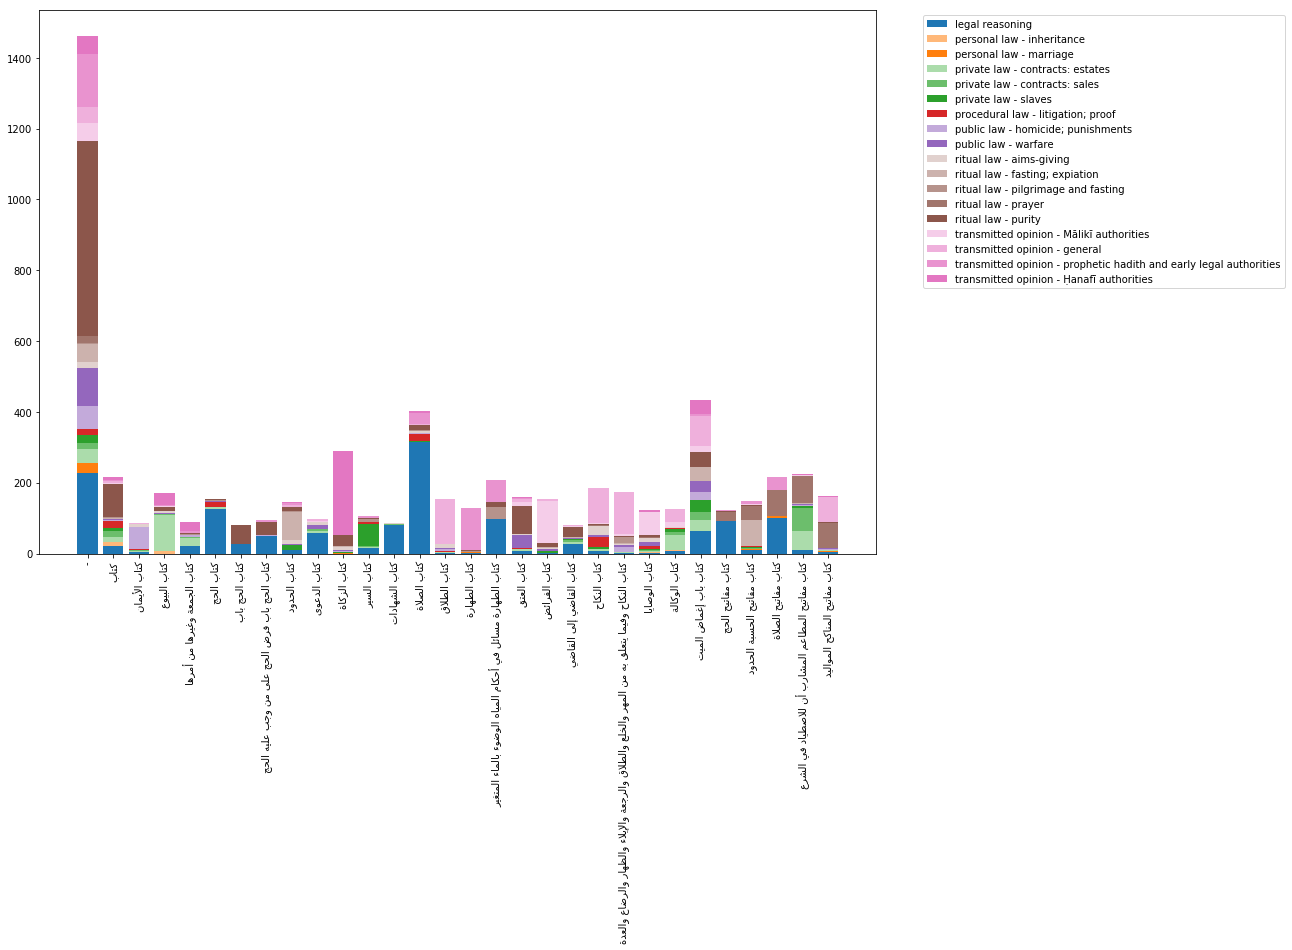

In [57]:
# The 30 most common volume names
voltitles = metadata_newind['Level1Title'].value_counts().head(30).index
meta_sub = metadata_newind[metadata_newind.Level1Title.isin(voltitles)]
plot_bars_per_topic(meta_sub, topic_names, 'Level1Title', reshape_col1=True, aggfunc=len)

0 باب
1 مسألة
2 باب السلم
3 باب الرجوع عن الشهادة
4 باب الصرف
5 باب حد القذف
6 باب ما
7 باب ما جاء في
8 باب موجبات الدية والعاقلة والكفارة تقدم الكلام على لفظ الدية في الباب قبله والعاقلة سموا بذلك لأنهم يعقلون الإبل بفناء دار القتيل وقيل لأنهم يمنعون عنه والعقل المنع وقيل لإعطائها العقل الذي هو الدية والكفارة مأخوذة من الكفر وهو الستر كما تقدم في بابها صاح على صبي لا يميز أي وكذا ضعيف التمييز كما قاله الإمام على طرف سطح أي أو بئر أو نهر فوقع بذلك فمات فدية مغلظة على العاقلة لأنه يتأثر بالصيحة الشديدة كثيرا فأحيل الهلاك عليها ولم يتعرض الجمهور للارتعاد وتعرض له الإمام والغزالي والرافعي وكأنه ملازم لهذه الحالة وفي قول قصاص لأن التأثير بها غالب وقياس القائل بهذا أن يوجب دية مغلظة على الجاني ولو كان الصبي المصيح عليه بأرض فمات أو صاح على بالغ بطرف سطح فسقط ومات فلا دية في الأصح لندرة الموت بذلك والحالة هذه والثاني تجب أما في الصبي فكما لو سقط من سطح وأما في البالغ فلأنه مع الغفلة كالصبي وشهر سلاح كصياح أي وكذا التهديد الشديد ومراهق متيقظ كبالغ أي فلا دية فيه على الأصح كما مضى فرع المجنون 

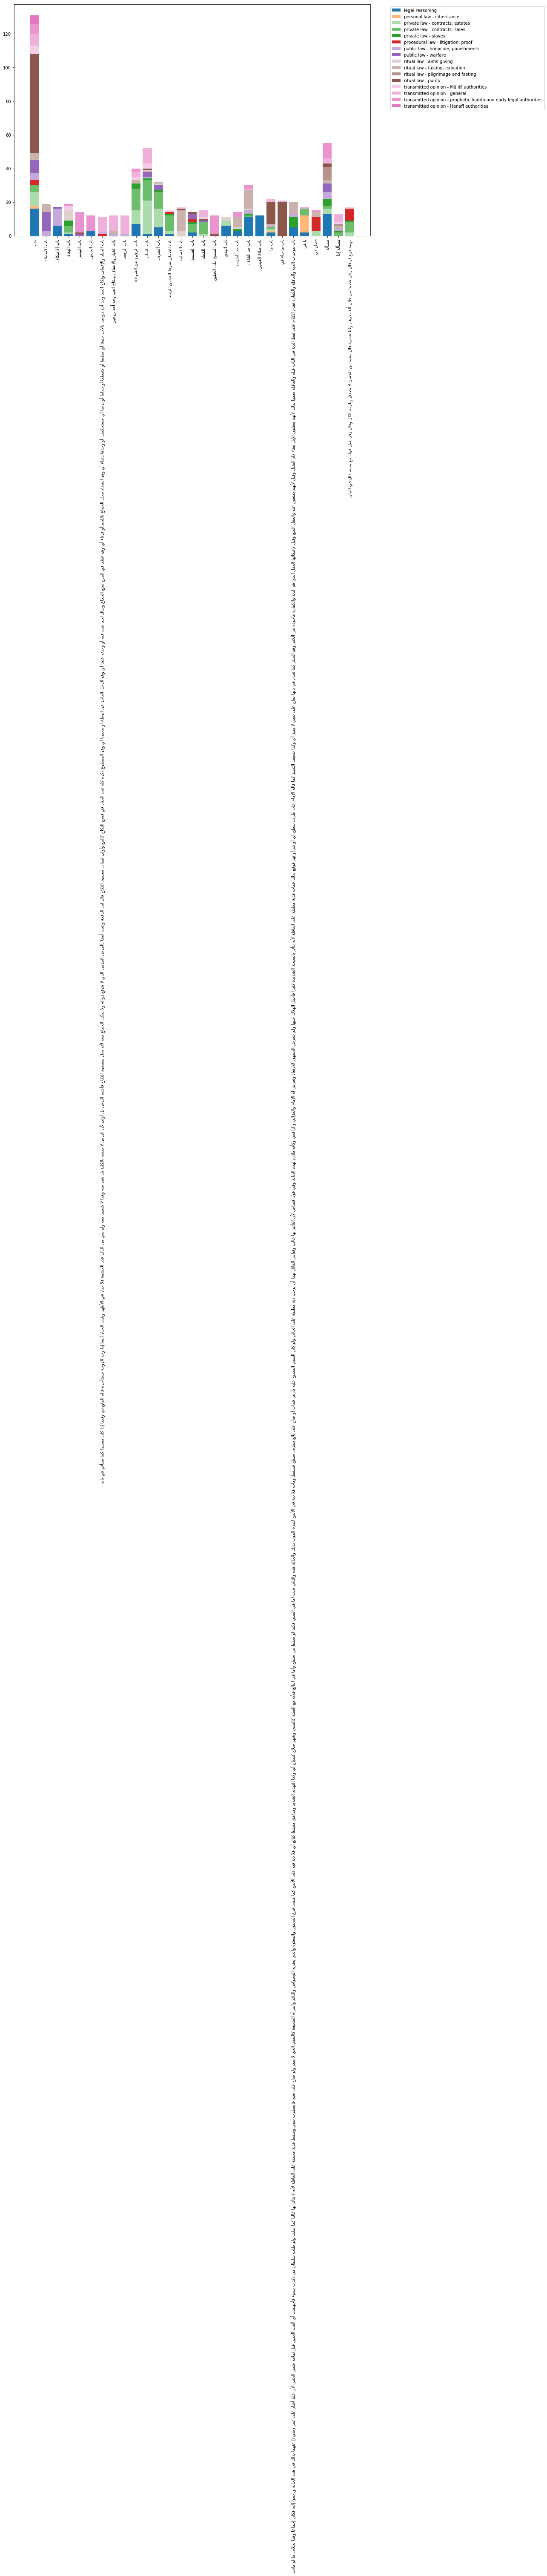

In [58]:
# The 30 most common chapter names
voltitles = metadata_newind['Level2Title'].value_counts().head(30)[1:].index
for i, v in enumerate(voltitles):
    print(i, v)
meta_sub = metadata_newind[metadata_newind.Level2Title.isin(voltitles)]
plot_bars_per_topic(meta_sub, topic_names, 'Level2Title', reshape_col1=True, aggfunc=len)